# Feature Engineering + Modeling

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import prince
import seaborn as sns

from feature import feature_selection, combine_features, visualize_feature_importance, perform_pca, plot_knee, plot_explained_variance
from modeling import train_model
from imblearn.over_sampling import SMOTE


from matplotlib.font_manager import FontProperties, findSystemFonts
font_path = '/Users/liang/Library/Fonts/STHeiti Medium.ttc'
font_prop = FontProperties(fname=font_path)

import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [34]:
# # 列出所有系統字體
# for font in findSystemFonts(fontpaths=None):
#     print(font)

# # 支持中文的字體
# chinese_fonts = [font for font in findSystemFonts() if "PingFang" in font or "Songti" in font or "Heiti" in font]
# print("可用的中文字體:", chinese_fonts)


In [35]:
# Input history .csv file and Audio embedding
data_folder = "use_data/"

train_embeddings = pd.read_csv(data_folder + "train_embeddings.csv", header=None)
test_embeddings = pd.read_csv(data_folder + "test_embeddings.csv", header=None)
train_history = pd.read_csv(data_folder + "train_history.csv")
test_history = pd.read_csv(data_folder + "test_history.csv")
y_train = np.load(data_folder + "train_label.npy")
y_test = np.load(data_folder + "test_label.npy")

# XGB只接受 從 0 開始
y_train = y_train - 1
y_test = y_test - 1

print("Train Embeddings: ", train_embeddings.shape)
print("Test Embeddings: ", test_embeddings.shape)
print("Train History: ", train_history.shape)
print("Test History: ", test_history.shape)
print("Train Labels: ", y_train.shape)
print("Test Labels: ", y_test.shape)

Train Embeddings:  (1000, 768)
Test Embeddings:  (500, 768)
Train History:  (1000, 26)
Test History:  (500, 26)
Train Labels:  (1000,)
Test Labels:  (500,)


## Feature Engineering

### 1. Use the feature both important foe LightGBM and Logistic Regression

In [36]:
models, importances = feature_selection(train_history, y_train)

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 24
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Info] Start training from score -1.514128
[LightGBM] [Info] Start training from score -1.783791
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -3.442019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training Logistic Regression...


/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Visualizing LightGBM Feature Importance...


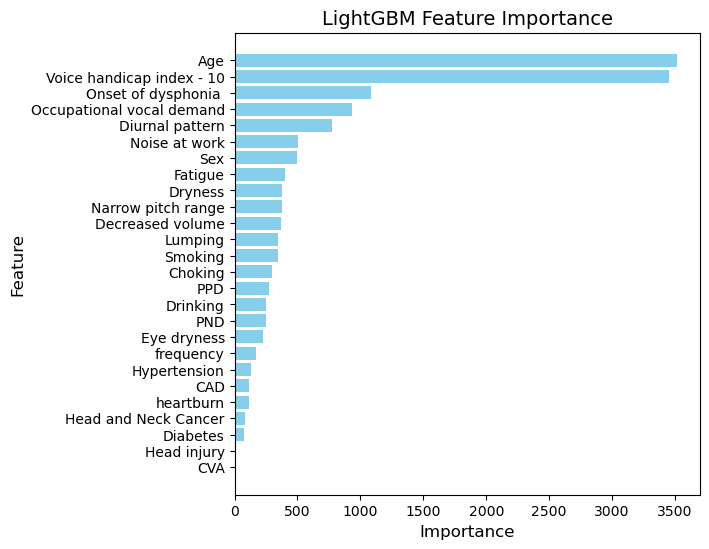

Visualizing Logistic Regression Feature Importance (Average Importance Across 5 Classes)...


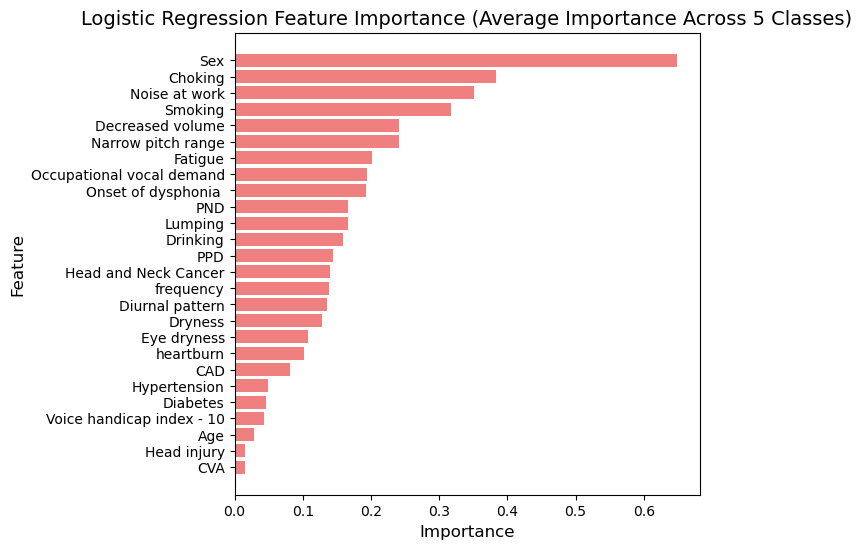

In [37]:
visualize_feature_importance("LightGBM", importances['LightGBM'], importance_col='importance', feature_col='feature', color='skyblue')
visualize_feature_importance("Logistic Regression", importances['Logistic'], 'avg_importance', 'feature', 'lightcoral', "Feature Importance (Average Importance Across 5 Classes)")


In [38]:
selected_features = combine_features(importances, k=17)

Method: intersection
Selected Features:  ['Sex', 'Lumping', 'Smoking', 'Drinking', 'Choking', 'Noise at work', 'Occupational vocal demand', 'Diurnal pattern', 'Dryness', 'Narrow pitch range', 'Decreased volume', 'Onset of dysphonia ', 'PND', 'Fatigue', 'PPD']
Number of Selected Features:  15


In [39]:
X1_train = train_history[selected_features]
X1_test = test_history[selected_features]
print("X1_train: ", X1_train.shape)
print("X1_test: ", X1_test.shape)

X1_train:  (1000, 15)
X1_test:  (500, 15)


### 2. PCA 嗓音資料

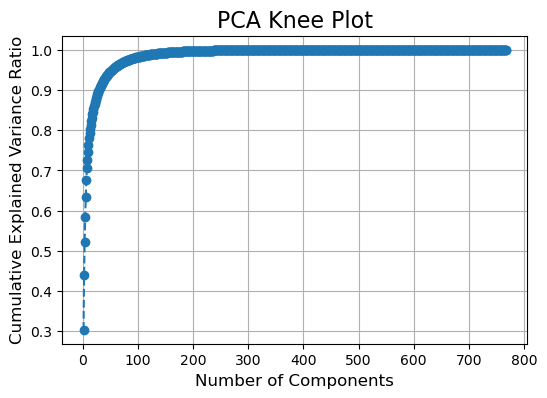

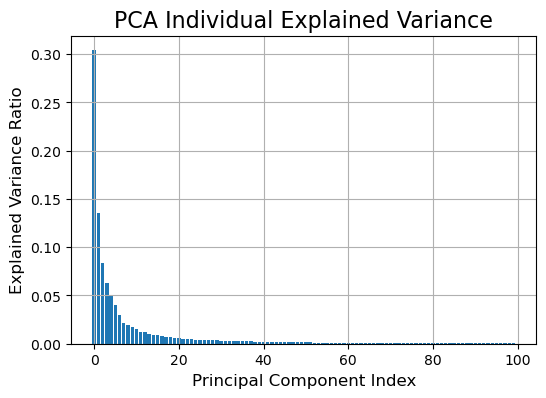

In [40]:
train_pca, test_pca, pca = perform_pca(train_embeddings, test_embeddings)
plot_knee(pca)
plot_explained_variance(pca)

In [41]:
pca_models, pca_importances = feature_selection(train_pca, y_train)

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 768
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Info] Start training from score -1.514128
[LightGBM] [Info] Start training from score -1.783791
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -3.442019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Visualizing LightGBM Feature Importance...


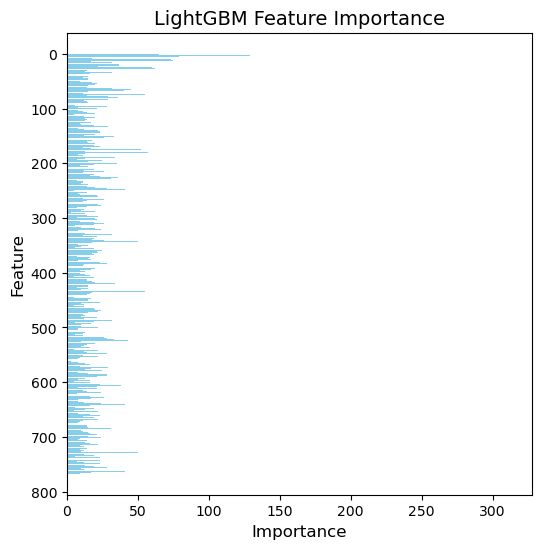

Visualizing Logistic Regression Feature Importance (Average Importance Across 5 Classes)...


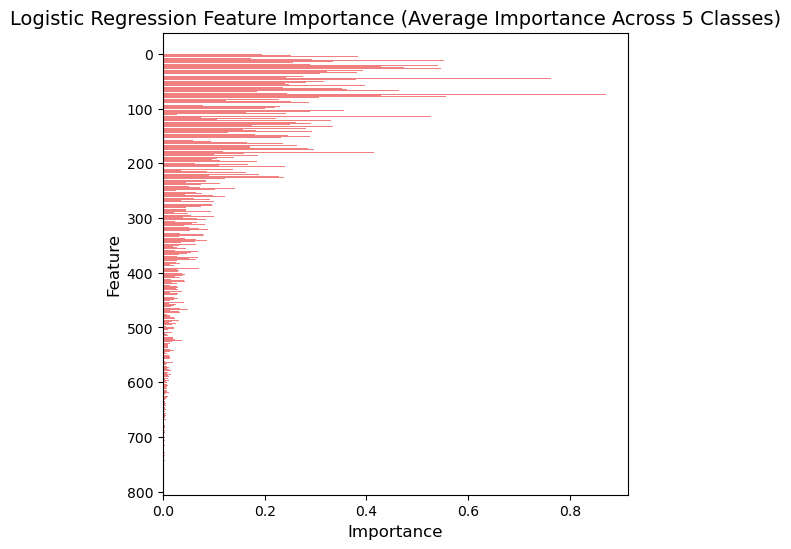

In [42]:
visualize_feature_importance("LightGBM", pca_importances['LightGBM'], importance_col='importance', feature_col='feature', color='skyblue')
visualize_feature_importance("Logistic Regression", pca_importances['Logistic'], 'avg_importance', 'feature', 'lightcoral', "Feature Importance (Average Importance Across 5 Classes)")


In [43]:
selected_features = combine_features(pca_importances, "union", k=20)

Method: union
Selected Features:  [0, 1, 3, 5, 6, 7, 10, 11, 12, 15, 21, 22, 25, 27, 543, 33, 38, 42, 45, 46, 175, 434, 180, 55, 62, 66, 67, 74, 717, 77, 78, 79, 731, 609, 114, 121]
Number of Selected Features:  36


In [44]:
X2_train = train_embeddings[selected_features]
X2_test = test_embeddings[selected_features]
print("X2_train: ", X2_train.shape)
print("X2_test: ", X2_test.shape)

X2_train:  (1000, 36)
X2_test:  (500, 36)


### Visualizing the audio data by PCA

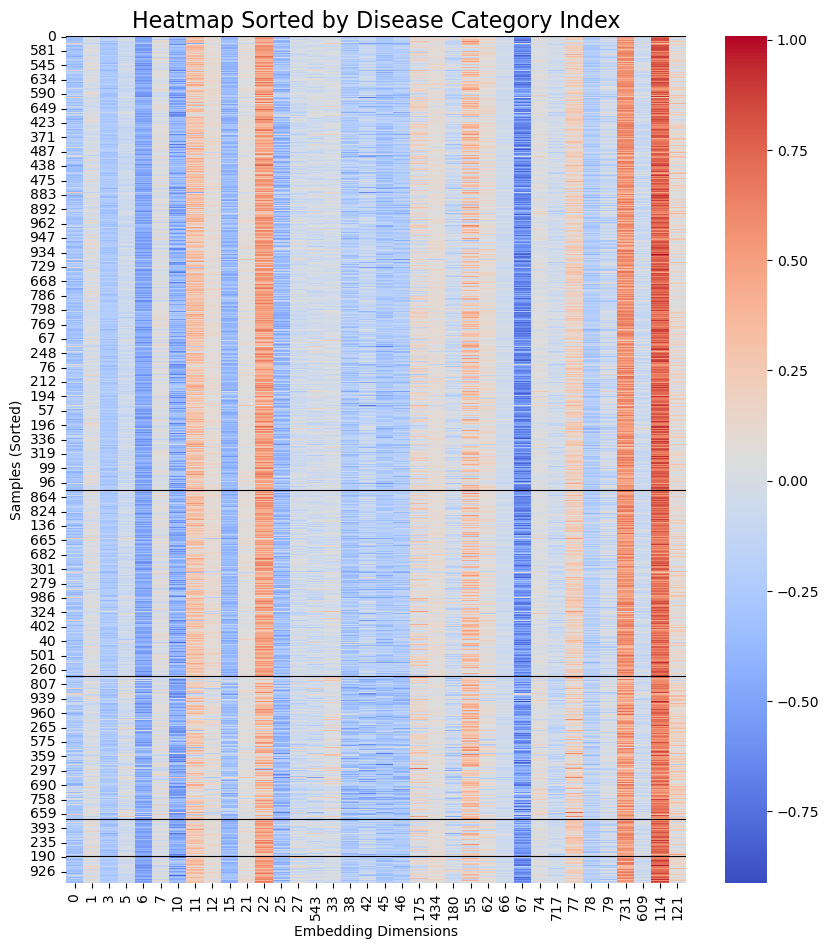

In [45]:
disease_sort_index = np.load("mid_data/disease_sort_index.npy")
disease_sort = np.load("mid_data/disease_sort.npy")
group_boundaries = np.cumsum(np.bincount(disease_sort))[:-1]

sorted_embeddings = X2_train.iloc[disease_sort_index, :]

# 繪製熱圖
plt.figure(figsize=(10, 11))
ax = sns.heatmap(
    sorted_embeddings,
    annot=False,
    cmap="coolwarm",
    cbar=True
)

for boundary in group_boundaries:
    ax.axhline(boundary, color='black', linewidth=0.8)  # 橫向分隔線

plt.title("Heatmap Sorted by Disease Category Index", fontsize=16)
plt.xlabel("Embedding Dimensions")
plt.ylabel("Samples (Sorted)")
plt.show()

### 3. Combine the medical history data and voice data

In [46]:
# Combine the two sets of features
X3_train = pd.concat([X1_train, X2_train], axis=1)
X3_train.columns = X3_train.columns.astype(str)

X3_test = pd.concat([X1_test, X2_test], axis=1)
X3_test.columns = X3_test.columns.astype(str)
print("X3_train: ", X3_train.shape)
print("X3_test: ", X3_test.shape)

X3_train:  (1000, 51)
X3_test:  (500, 51)


### 4. Multiple Correspondence Analysis (MCA)

In [47]:
cat_indices = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]
cont_indices = [i for i in range(X3_train.shape[1]) if i not in cat_indices]


X3_train_cat = X3_train.iloc[:, cat_indices]
X3_train_cont = X3_train.iloc[:, cont_indices]
X3_test_cat = X3_test.iloc[:, cat_indices]
X3_test_cont = X3_test.iloc[:, cont_indices]

In [48]:
mca = prince.MCA(n_components=40, random_state=42)
mca_result = mca.fit(X3_train_cat)

eigenvalues = mca.eigenvalues_
cumulative_variance = mca.cumulative_percentage_of_variance_
# print("特徵值:", eigenvalues)
# print("累積解釋變異:", cumulative_variance)

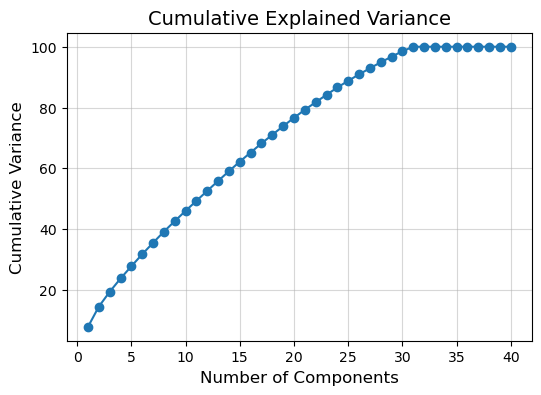

In [49]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance', fontsize=14)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Variance', fontsize=12)
plt.grid(alpha=0.5)
plt.show()


In [50]:
# Training categorical embeddings (取前 25 維)
X3_train_cat_embedding = mca_result.row_coordinates(X3_train_cat)
X3_train_cat_embedding = X3_train_cat_embedding.iloc[:, :25]
print("Train Categorical Embedding Shape:", X3_train_cat_embedding.shape)

# Testing categorical embeddings (取前 25 維)
X3_test_cat_embedding_full = mca.transform(X3_test_cat)  # Transform 測試集
X3_test_cat_embedding = X3_test_cat_embedding_full.iloc[:, :25]
print("Test Categorical Embedding Shape:", X3_test_cat_embedding.shape)

# Name the columns (otherwise they will duplicated with .wav data)
X3_train_cat_embedding.columns = [f"cat_{i}" for i in range(25)]
X3_test_cat_embedding.columns = [f"cat_{i}" for i in range(25)]

Train Categorical Embedding Shape: (1000, 25)
Test Categorical Embedding Shape: (500, 25)


In [51]:
# Combine categorical and continuous embeddings
X4_train = pd.concat([X3_train_cat_embedding, X3_train_cont], axis=1)
X4_train.columns = X4_train.columns.astype(str)

X4_test = pd.concat([X3_test_cat_embedding, X3_test_cont], axis=1)
X4_test.columns = X4_test.columns.astype(str)

print("X4_train: ", X4_train.shape)
print("X4_test: ", X4_test.shape)

X4_train:  (1000, 62)
X4_test:  (500, 62)


### 5. SMOTE

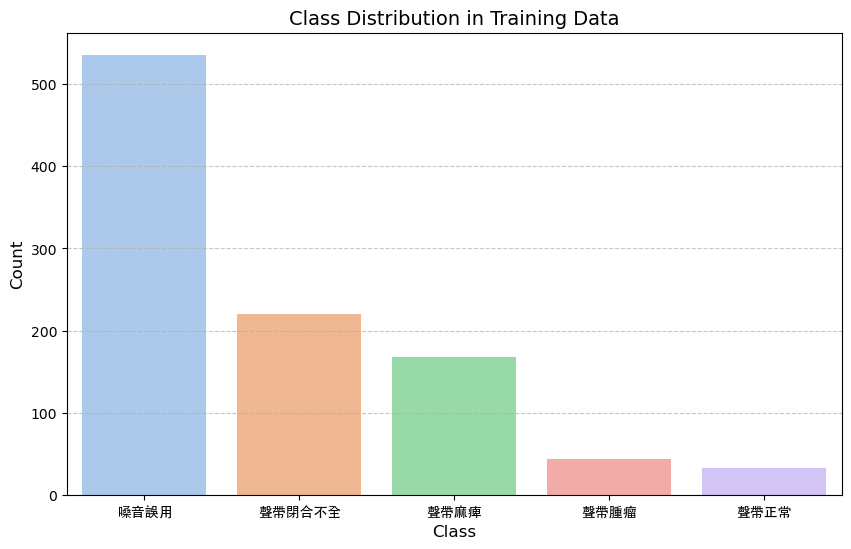

In [52]:
if isinstance(y_train, (list, np.ndarray)):
    y_train = pd.Series(y_train, name="Class")

class_counts = y_train.value_counts().sort_index()

plt.figure(figsize=(10 ,6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="pastel")
plt.title("Class Distribution in Training Data", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(range(5), ['嗓音誤用', '聲帶閉合不全', '聲帶麻痺', '聲帶腫瘤', '聲帶正常'], fontsize=10, font_properties=font_prop)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


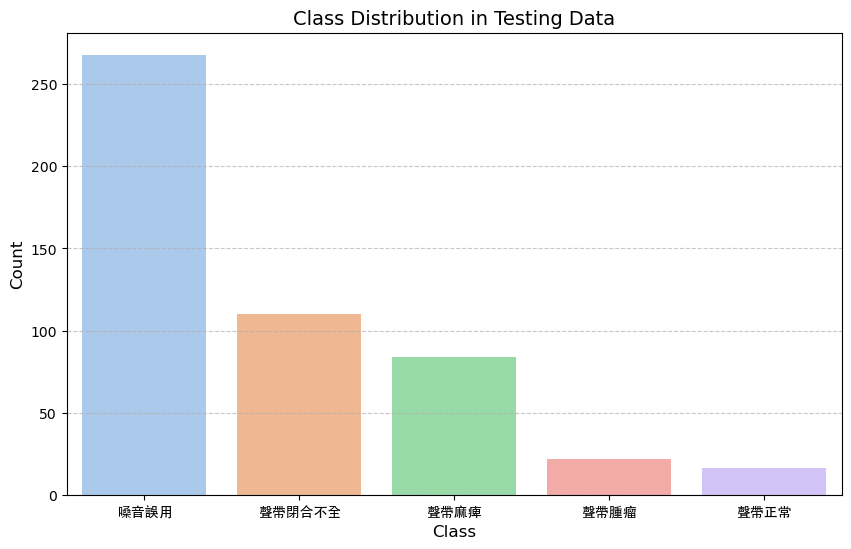

In [53]:
if isinstance(y_test, (list, np.ndarray)):
    y_test= pd.Series(y_test, name="Class")

class_counts = y_test.value_counts().sort_index()

plt.figure(figsize=(10 ,6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="pastel")
plt.title("Class Distribution in Testing Data", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(range(5), ['嗓音誤用', '聲帶閉合不全', '聲帶麻痺', '聲帶腫瘤', '聲帶正常'], fontsize=10, font_properties=font_prop)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [54]:
print("Original class distribution in y_train:", Counter(y_train))

# 設定 SMOTE 過採樣策略，將少數類別補到至少 100 筆
target_samples = 100
smote = SMOTE(
    sampling_strategy=lambda y: {
        label: target_samples if count < target_samples else count
        for label, count in Counter(y).items()
    },
    random_state=42
)

X5_train, y5_train = smote.fit_resample(X4_train, y_train)

# 確認平衡後的類別分佈
print("Balanced class distribution in y_train:", Counter(y5_train))


Original class distribution in y_train: Counter({0: 536, 1: 220, 2: 168, 3: 44, 4: 32})
Balanced class distribution in y_train: Counter({0: 536, 1: 220, 2: 168, 3: 100, 4: 100})


## Modeling & Evalution

### 1. Medical History Data (Feature Selection)

In [55]:
logistic_model, logistic_performance = train_model("Logistic", X1_train, y_train, X1_test, y_test)
svm_model, svm_performance = train_model("SVM", X1_train, y_train, X1_test, y_test)
xgb_model, xgb_performance = train_model("XGB", X1_train, y_train, X1_test, y_test)
lgbm_model, lgbm_performance = train_model("LGBM", X1_train, y_train, X1_test, y_test)

Training Logistic...
Logistic Performance:
  Accuracy: 0.6420
  Precision: 0.5753
  Recall: 0.6420
  F1-Score: 0.6029

Training SVM...


/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVM Performance:
  Accuracy: 0.6940
  Precision: 0.6316
  Recall: 0.6940
  F1-Score: 0.6548

Training XGB...
XGB Performance:
  Accuracy: 0.6420
  Precision: 0.6095
  Recall: 0.6420
  F1-Score: 0.6211

Training LGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 15
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Info] Start training from score -1.514128
[LightGBM] [Info] Start training from score -1.783791
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -3.442019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [56]:
print("Logistic Regression Performance: ", logistic_performance)
print("SVM Performance: ", svm_performance)
print("XGBoost Performance: ", xgb_performance)
print("LightGBM Performance: ", lgbm_performance)

Logistic Regression Performance:  {'Accuracy': 0.642, 'Recall': 0.642, 'Precision': 0.5752769513965096, 'F1-Score': 0.6029386030325627}
SVM Performance:  {'Accuracy': 0.694, 'Recall': 0.694, 'Precision': 0.6316038350789482, 'F1-Score': 0.6547625197302339}
XGBoost Performance:  {'Accuracy': 0.642, 'Recall': 0.642, 'Precision': 0.6095110635537582, 'F1-Score': 0.6210508196253701}
LightGBM Performance:  {'Accuracy': 0.672, 'Recall': 0.672, 'Precision': 0.6404397516462031, 'F1-Score': 0.6513382413441775}


### 2. Voice Data PCA

In [57]:
logistic_model, logistic_performance = train_model("Logistic", X2_train, y_train, X2_test, y_test)
svm_model, svm_performance = train_model("SVM", X2_train, y_train, X2_test, y_test)
xgb_model, xgb_performance = train_model("XGB", X2_train, y_train, X2_test, y_test)
lgbm_model, lgbm_performance = train_model("LGBM", X2_train, y_train, X2_test, y_test)

Training Logistic...
Logistic Performance:
  Accuracy: 0.6080
  Precision: 0.5216
  Recall: 0.6080
  F1-Score: 0.5177

Training SVM...


/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVM Performance:
  Accuracy: 0.5920
  Precision: 0.4310
  Recall: 0.5920
  F1-Score: 0.4758

Training XGB...
XGB Performance:
  Accuracy: 0.5920
  Precision: 0.5342
  Recall: 0.5920
  F1-Score: 0.5546

Training LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9177
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 36
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Info] Start training from score -1.514128
[LightGBM] [Info] Start training from score -1.783791
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -3.442019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [58]:
print("Logistic Regression Performance: ", logistic_performance)
print("SVM Performance: ", svm_performance)
print("XGBoost Performance: ", xgb_performance)
print("LightGBM Performance: ", lgbm_performance)

Logistic Regression Performance:  {'Accuracy': 0.608, 'Recall': 0.608, 'Precision': 0.5215756931526264, 'F1-Score': 0.5176855810954092}
SVM Performance:  {'Accuracy': 0.592, 'Recall': 0.592, 'Precision': 0.4310239417736066, 'F1-Score': 0.4757853824845515}
XGBoost Performance:  {'Accuracy': 0.592, 'Recall': 0.592, 'Precision': 0.5341891091364775, 'F1-Score': 0.5546047042052744}
LightGBM Performance:  {'Accuracy': 0.596, 'Recall': 0.596, 'Precision': 0.5262492608938453, 'F1-Score': 0.5476652110509506}


### 3. Medical History Data (Feature Selection) + Voice Data PCA

In [59]:
logistic_model, logistic_performance = train_model("Logistic", X3_train, y_train, X3_test, y_test)
svm_model, svm_performance = train_model("SVM", X3_train, y_train, X3_test, y_test)
xgb_model, xgb_performance = train_model("XGB", X3_train, y_train, X3_test, y_test)
lgbm_model, lgbm_performance = train_model("LGBM", X3_train, y_train, X3_test, y_test)

Training Logistic...
Logistic Performance:
  Accuracy: 0.7180
  Precision: 0.6576
  Recall: 0.7180
  F1-Score: 0.6835

Training SVM...


/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVM Performance:
  Accuracy: 0.7120
  Precision: 0.6523
  Recall: 0.7120
  F1-Score: 0.6731

Training XGB...
XGB Performance:
  Accuracy: 0.7180
  Precision: 0.6619
  Recall: 0.7180
  F1-Score: 0.6867

Training LGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9229
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 51
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Info] Start training from score -1.514128
[LightGBM] [Info] Start training from score -1.783791
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -3.442019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [60]:
print("Logistic Regression Performance: ", logistic_performance)
print("SVM Performance: ", svm_performance)
print("XGBoost Performance: ", xgb_performance)
print("LightGBM Performance: ", lgbm_performance)

Logistic Regression Performance:  {'Accuracy': 0.718, 'Recall': 0.718, 'Precision': 0.6576023312666509, 'F1-Score': 0.6834928470635929}
SVM Performance:  {'Accuracy': 0.712, 'Recall': 0.712, 'Precision': 0.6522834537323702, 'F1-Score': 0.6730916307161345}
XGBoost Performance:  {'Accuracy': 0.718, 'Recall': 0.718, 'Precision': 0.661862049062049, 'F1-Score': 0.6867283514890207}
LightGBM Performance:  {'Accuracy': 0.714, 'Recall': 0.714, 'Precision': 0.6545343209876544, 'F1-Score': 0.6796240013598505}


### 4. Medical History Data (Feature Selection) + Voice Data PCA + MCA

In [61]:
logistic_model, logistic_performance = train_model("Logistic", X4_train, y_train, X4_test, y_test)
svm_model, svm_performance = train_model("SVM", X4_train, y_train, X4_test, y_test)
xgb_model, xgb_performance = train_model("XGB", X4_train, y_train, X4_test, y_test)
lgbm_model, lgbm_performance = train_model("LGBM", X4_train, y_train, X4_test, y_test)

Training Logistic...
Logistic Performance:
  Accuracy: 0.7380
  Precision: 0.6973
  Recall: 0.7380
  F1-Score: 0.7044

Training SVM...


/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVM Performance:
  Accuracy: 0.7000
  Precision: 0.6443
  Recall: 0.7000
  F1-Score: 0.6529

Training XGB...
XGB Performance:
  Accuracy: 0.7240
  Precision: 0.6632
  Recall: 0.7240
  F1-Score: 0.6892

Training LGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15557
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 62
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Info] Start training from score -1.514128
[LightGBM] [Info] Start training from score -1.783791
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -3.442019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [62]:
print("Logistic Regression Performance: ", logistic_performance)
print("SVM Performance: ", svm_performance)
print("XGBoost Performance: ", xgb_performance)
print("LightGBM Performance: ", lgbm_performance)

Logistic Regression Performance:  {'Accuracy': 0.738, 'Recall': 0.738, 'Precision': 0.6973249277646442, 'F1-Score': 0.7043942378533483}
SVM Performance:  {'Accuracy': 0.7, 'Recall': 0.7, 'Precision': 0.644273618284599, 'F1-Score': 0.6528849872242791}
XGBoost Performance:  {'Accuracy': 0.724, 'Recall': 0.724, 'Precision': 0.6631731574566178, 'F1-Score': 0.6892374307265549}
LightGBM Performance:  {'Accuracy': 0.714, 'Recall': 0.714, 'Precision': 0.6523945841392649, 'F1-Score': 0.6775868772678395}


### 5. Medical History Data (Feature Selection) + Voice Data PCA + MCA + SMOTE

In [63]:
logistic_model, logistic_performance = train_model("Logistic", X5_train, y5_train, X4_test, y_test)
svm_model, svm_performance = train_model("SVM", X5_train, y5_train, X4_test, y_test)
xgb_model, xgb_performance = train_model("XGB", X5_train, y5_train, X4_test, y_test)
lgbm_model, lgbm_performance = train_model("LGBM", X5_train, y5_train, X4_test, y_test)

Training Logistic...
Logistic Performance:
  Accuracy: 0.7200
  Precision: 0.7055
  Recall: 0.7200
  F1-Score: 0.7088

Training SVM...


/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/liang/anaconda3/envs/Pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVM Performance:
  Accuracy: 0.6980
  Precision: 0.6420
  Recall: 0.6980
  F1-Score: 0.6503

Training XGB...
XGB Performance:
  Accuracy: 0.7000
  Precision: 0.6459
  Recall: 0.7000
  F1-Score: 0.6693

Training LGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15569
[LightGBM] [Info] Number of data points in the train set: 1124, number of used features: 62
[LightGBM] [Info] Start training from score -0.740515
[LightGBM] [Info] Start training from score -1.631021
[LightGBM] [Info] Start training from score -1.900685
[LightGBM] [Info] Start training from score -2.419479
[LightGBM] [Info] Start training from score -2.419479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [64]:
print("Logistic Regression Performance: ", logistic_performance)
print("SVM Performance: ", svm_performance)
print("XGBoost Performance: ", xgb_performance)
print("LightGBM Performance: ", lgbm_performance)

Logistic Regression Performance:  {'Accuracy': 0.72, 'Recall': 0.72, 'Precision': 0.7055010464765358, 'F1-Score': 0.7087896687615325}
SVM Performance:  {'Accuracy': 0.698, 'Recall': 0.698, 'Precision': 0.6420268556881147, 'F1-Score': 0.6502911789031495}
XGBoost Performance:  {'Accuracy': 0.7, 'Recall': 0.7, 'Precision': 0.6458786432079092, 'F1-Score': 0.6693091878075972}
LightGBM Performance:  {'Accuracy': 0.72, 'Recall': 0.72, 'Precision': 0.6636202808774239, 'F1-Score': 0.6867856081417248}
